# In this notebook we will attempt to run Bayesian Regression on the full NBA dataset for 2018/19 season using priors from player contracts.

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

data = pd.read_csv("../data/shifts_data_final_2018_19.csv")
data.drop(data.columns[0], axis = 1, inplace = True)
data.head()

,point_diff_per_100,home_team,away_team,0,1,2,3,4,5,6,...,519,520,521,522,523,524,525,526,527,528
0,-36.458333,Celtics,Nuggets,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,Celtics,Nuggets,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
priors_df = pd.read_csv("../data/priors_team_contract_formatted.csv")
priors_df.drop(priors_df.columns[0], axis = 1, inplace = True)
priors_df.head()


,name,mu,sd
0,Marcus Morris,0.000000,5
1,Jayson Tatum,-0.718928,5
2,Jaylen Brown,-1.127152,5
3,Terry Rozier,-1.692371,5
4,Robin Lopez,3.284328,5


In [3]:
prior_means = np.array(priors_df.mu)
prior_sd = np.array(priors_df.sd)
prior_sd4 = prior_sd - 1 # set all standard devs to 4
prior_sd3 = prior_sd - 2 # set all standard devs to 3
prior_sd2 = prior_sd - 3 # set all standard devs to 2
prior_sd1 = prior_sd - 4 # set all standard devs to 1

In [4]:
# store home and away teams for potential use later when we incorporate team ratings
home_teams = data['home_team']
away_teams = data['away_team']
# now drop these columns from the main training dataframe
data.drop(['home_team', 'away_team'], axis = 1, inplace = True)
data.head()

,point_diff_per_100,0,1,2,3,4,5,6,7,8,...,519,520,521,522,523,524,525,526,527,528
0,-36.458333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# need to rename columns now since numbers confuse pymc3
new_cols = []
for i in range(np.shape(data)[1]):
    if i == 0:
        new_cols.append("point_diff")
    else:
        new_cols.append("p" + str(i-1))

x_df = data.iloc[:20000,]
x_df.columns = new_cols
x_df

,point_diff,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p519,p520,p521,p522,p523,p524,p525,p526,p527,p528
0,-36.458333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-20.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,36.168981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,-39.859694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,13.086265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Bayesian Regression

After fixing our measurement of +/- to be on the scale of per 100 possessions instead of per possession, the Bayesian Regression model now seems to give quite reasonable estimates. Also - we fit the model below using the `shape` parameter rather than a list comprehension and it seems to work fine.

Note - Steph Curry is index 317 and Lebron James is index 225, so for sanity checks we can check these players' coefficients compared to a random player. 


We will run the cell below a few separate times with each value of the prior sigmas, then we will investigate the results and select the sigma that yielded the most reasonable results. I don't have a robust method in mind for evaluating each of the choices of sigma, so for now we can just manually inspect the results to see if they appear reasonable or not (for example, we should not see a player like Jared Dudley in the top 20 highest +/- ratings).

In [6]:
x = np.array(x_df.iloc[:,1:])
y = np.array(x_df.iloc[:,0])

x_shape = np.shape(x)[1]

with pm.Model() as model5:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10) # arbitrarily defined
    intercept = pm.Normal("Intercept", 0, sigma=20) # arbitrarily defined
    x_prior_means = prior_means # defined above
    x_prior_sigmas = prior_sd # defined above
#     x_prior_means = np.zeros(x_shape) # just testing with mean zero to compare to ridge
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = x_shape) # original method - no list comprehension

    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y) # original method - no list comprehension
    
    trace5 = pm.sample(1000, tune = 1000, cores = 1)
    
with pm.Model() as model4:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10) # arbitrarily defined
    intercept = pm.Normal("Intercept", 0, sigma=20) # arbitrarily defined
    x_prior_means = prior_means # defined above
    x_prior_sigmas = prior_sd4 # defined above
#     x_prior_means = np.zeros(x_shape) # just testing with mean zero to compare to ridge
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = x_shape) # original method - no list comprehension

    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y) # original method - no list comprehension
    
    trace4 = pm.sample(1000, tune = 1000, cores = 1)
    
with pm.Model() as model3:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10) # arbitrarily defined
    intercept = pm.Normal("Intercept", 0, sigma=20) # arbitrarily defined
    x_prior_means = prior_means # defined above
    x_prior_sigmas = prior_sd3 # defined above
#     x_prior_means = np.zeros(x_shape) # just testing with mean zero to compare to ridge
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = x_shape) # original method - no list comprehension

    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y) # original method - no list comprehension
    
    trace3 = pm.sample(1000, tune = 1000, cores = 1)
    
with pm.Model() as model2:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10) # arbitrarily defined
    intercept = pm.Normal("Intercept", 0, sigma=20) # arbitrarily defined
    x_prior_means = prior_means # defined above
    x_prior_sigmas = prior_sd2 # defined above
#     x_prior_means = np.zeros(x_shape) # just testing with mean zero to compare to ridge
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = x_shape) # original method - no list comprehension

    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y) # original method - no list comprehension
    
    trace2 = pm.sample(1000, tune = 1000, cores = 1)
    
with pm.Model() as model1:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10) # arbitrarily defined
    intercept = pm.Normal("Intercept", 0, sigma=20) # arbitrarily defined
    x_prior_means = prior_means # defined above
    x_prior_sigmas = prior_sd1 # defined above
#     x_prior_means = np.zeros(x_shape) # just testing with mean zero to compare to ridge
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = x_shape) # original method - no list comprehension

    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y) # original method - no list comprehension
    
    trace1 = pm.sample(1000, tune = 1000, cores = 1)
    
    

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 929 seconds.
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 920 seconds.
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 878 seconds.
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 818 seconds.
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 723 seconds.


In [43]:
# This was using the list comp method:
with model:
    print((intercept + sum([x_coeff[i] * x[:,i] for i in range(529)])))

Elemwise{add,no_inplace}.0


In [50]:
# This is using the shape method:
with model:
    print(x_coeff)

x ~ Normal


In [7]:
with model5:
    results_df5 = az.summary(trace5)
    
with model4:
    results_df4 = az.summary(trace4)
    
with model3:
    results_df3 = az.summary(trace3)
    
with model2:
    results_df2 = az.summary(trace2)
    
with model1:
    results_df1 = az.summary(trace1)

In [64]:
np.std(results_df['mean'])
np.std(prior_means)

2.619570495497698

## Assessing Results of Bayesian Regression in Context (running on only 10k shifts)

**Before adjusting for teams, uncentered contract priors**, the highest coefficients (in order) are:
* Steph Curry
* James Harden
* Al Horford (he was a solid player on a good Celtics team in 2018/19 looking at box score statistics)
    * Horford also had a very high salary 28,928,710 this season which probably is contributing to this high coefficient
* LeBron James
* Giannis
* Paul Millsap
* Mike Conley
* Russel Westbrook
* Marc Gasol
* Chris Paul

This seems reasonable. The Bayesian regression seems to be learning the right things now. The coefficients are not centered still, since we have not yet centered contracts properly, but the relative ordering of coefficients seems to be quite reasonable. Perhaps the contract is injecting a bit too much bias into the coefficients, but this will hopefully improve once we add more to the priors (team ratings, more specific standard deviations based on contract value).

**After adjusting for teams (without negating or centering)**, the highest coefficients (in order) are:
* James Harden
* Al Horford
* Steph Curry
* Giannis
* Eric Gordon
* Marc Gasol
* LeBron James
* Ricky Rubio
* Paul Millsap
* Chris Paul

**NOTE**: The way we adjusted for teams seems incorrect. We simply averaged the team rating with the contract prior to get a mean for each player. This doesn't really make sense - bad teams are currently bringing down the +/- of good players, and good teams are bringing up the +/- of bad players. We want the opposite - a bad player on a good team will naturally show a good +/-, but this doesn't necessarily mean the player is actually very good, rather he is just surrounded by other good players so his +/- appears better. So in this situation we would want to take the bad player and set his prior mean *lower* due to his team's high rating, so that his final coefficient ends up lower once the model inevitably sees his strong +/- in the training examples.

I think a reasonable course of action is to first center the team ratings, negate them, and then take a weighted average with contract priors. By negating the ratings we capture the notion that we should reduce the mean for players on good teams and increase the mean for players on bad teams.

Also - in order for this averaging to make sense, we may need to make sure that the team ratings are scaled proportionally to the contract priors, i.e. we can't have team ratings range from -3 to 3 while contract priors range from -8 to 8. We should scale based on contract priors since we constructed these under the assumption that 3mil contract value corresponds to 1 point of +/-. 

**Note** - I'm not sure about the statement above about scaling team ratings to match contract values. Team ratings were originally created based on regression onto +/- values, so these may alreaday be on a valid scale that is worth keeping untouched. We could try both methods I suppose.

**After adjusting for teams, negating, and centering both teams and contracts**, the highest coefficients are:
* Steph Curry
* Al Horford
* LeBron James
* Giannis
* James Harden
* Mike Conley
* Paul Millsap
* Russel Westbrook
* Marc Gasol
* Kent Bazemore 

Then the 11th player is Jared Dudley which is a bit bizarre.

### Cross Validation Results for Sigma (running on only 10k shifts):

With sigma = 5 we see the following top 10:
* Curry, Horford, Lebron, Giannis, Harden, Mike Conley, Millsap, Westbrook, Marc Gasol, Kent Bazemore (Jared Dudley is 11th)

With sigma = 4 the top 10 is:
* Curry, Lebron, Horford, Giannis, Harden, Mike Conley, Millsap, Westbrook, Marc Gasol, Damian Lillard (Jared Dudley is a bit lower now)

With sigma = 3 the top 10 is:
* Curry, Lebron, Giannis, Horford, Conley, Harden, Millsap, Westbrook, Dame, Chris Paul (Jared Dudley no longer shows up in top 19)

With sigma = 2 the top 10 is:
* Lebron, Curry, Conley, Westbrook, Giannis, Horford, Chris Paul, Millsap, Dame, Harden

With sigma = 1 the top 10 is:
* Lebron, Curry, Conley, Westbrook, Giannis, Horford, Chris Paul, Millsap, Dame, Harden

Note - Conley was very highly paid in 2018-19 (salary of about 30 million)

### Once we run this on 20k shifts instead of just 10k shifts we start to see different players show up with high coefficients

We begin to see players like Beal, AD, Blake Griffin, Hayward, Lowry, and others start showing up higher

In [65]:
priors_df.sort_values(by = ['mu']).tail(30)

,name,mu,sd
383,Nicolas Batum,4.473708,5
42,Anthony Davis,4.510138,5
505,Nikola Jokic,4.559092,5
386,Giannis Antetokounmpo,4.568149,5
403,Kevin Durant,4.609997,5
207,James Harden,4.616469,5
454,Jrue Holiday,4.654631,5
390,Zach LaVine,4.655594,5
30,Bradley Beal,4.717110,5
464,Aaron Gordon,4.826506,5


In [8]:
player_index_map = pd.read_csv("../data/player_index_map.csv")

In [54]:
player_index_map.loc[player_index_map.index == 505]
# player_index_map.player_name.iloc[300:350]

,Unnamed: 0,player_id,index,player_name
505,505,203999.0,505,Nikola Jokic


In [14]:
# with model5:
# #     print(results_df.loc['x[317]', 'mean'])
# #     print((results_df.loc[results_df['mean'] > 7]).sort_values(by=['mean']))
#     print((results_df5.loc[results_df5['mean'] > 5]).sort_values(by=['mean']))
# #     print(results_df.iloc[276])
    
# #     print(results_df.loc['x[167]', :])

print((results_df5.loc[results_df5['mean'] > 6]).sort_values(by=['mean']))
# results_df5.loc['x[338]']

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[59]    6.034  3.114   0.001   11.744      0.049    0.040    4110.0   
x[70]    6.266  3.723  -0.696   13.156      0.054    0.049    4800.0   
x[264]   6.314  3.112   0.206   11.709      0.053    0.043    3444.0   
x[244]   6.322  3.252   0.324   12.387      0.050    0.045    4313.0   
x[405]   6.322  3.283   0.519   12.760      0.053    0.048    3784.0   
x[203]   6.372  3.613  -0.286   13.213      0.054    0.049    4400.0   
x[465]   6.534  3.492   0.077   13.025      0.055    0.044    4011.0   
x[42]    6.561  3.457   0.128   13.099      0.053    0.043    4249.0   
x[95]    6.639  3.100   0.729   12.314      0.056    0.046    3082.0   
x[63]    6.703  3.447   0.188   12.958      0.058    0.050    3577.0   
x[425]   6.987  3.109   1.055   12.796      0.044    0.038    4843.0   
x[71]    7.036  3.234   1.226   13.422      0.052    0.042    3934.0   
x[28]    7.102  3.364   1.123   13.483      0.060    0.048    30

In [10]:
print((results_df4.loc[results_df4['mean'] > 5]).sort_values(by=['mean']))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[264]   5.113  2.886  -0.212   10.560      0.040    0.036    5242.0   
x[513]   5.126  3.055  -0.806   10.602      0.041    0.045    5500.0   
x[465]   5.153  2.821   0.022   10.493      0.048    0.040    3495.0   
x[81]    5.317  2.912  -0.133   10.504      0.046    0.039    4029.0   
x[70]    5.350  3.228  -0.309   11.570      0.047    0.046    4712.0   
x[112]   5.367  2.888   0.188   11.031      0.040    0.033    5332.0   
x[95]    5.388  2.783   0.370   10.998      0.044    0.042    3997.0   
x[405]   5.443  2.843  -0.206   10.431      0.044    0.035    4097.0   
x[60]    5.460  2.818   0.374   10.883      0.046    0.041    3850.0   
x[40]    5.478  2.966  -0.043   10.753      0.047    0.039    4048.0   
x[505]   5.501  2.875   0.296   10.950      0.042    0.036    4740.0   
x[203]   5.579  3.143  -0.665   11.107      0.048    0.043    4169.0   
x[291]   5.628  2.708   0.485   10.743      0.039    0.034    48

In [11]:
print((results_df3.loc[results_df3['mean'] > 5]).sort_values(by=['mean']))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[12]    5.271  2.397   1.216   10.218      0.035    0.031    4662.0   
x[112]   5.377  2.447   0.708   10.022      0.037    0.030    4366.0   
x[505]   5.451  2.398   0.901    9.997      0.038    0.030    3922.0   
x[28]    5.519  2.327   1.599    9.989      0.036    0.030    4199.0   
x[40]    5.525  2.384   0.974    9.785      0.039    0.032    3836.0   
x[291]   5.656  2.247   1.387    9.858      0.033    0.027    4609.0   
x[42]    5.719  2.331   1.253   10.009      0.035    0.029    4347.0   
x[358]   5.877  2.411   1.412   10.307      0.037    0.035    4207.0   
x[190]   5.949  2.374   1.503   10.469      0.033    0.028    5239.0   
x[425]   6.193  2.426   1.435   10.602      0.036    0.031    4545.0   
x[454]   6.221  2.454   1.348   10.671      0.032    0.028    5808.0   
x[244]   6.428  2.475   1.862   11.214      0.034    0.029    5309.0   
x[321]   6.430  2.506   1.527   10.981      0.036    0.030    49

In [12]:
print((results_df2.loc[results_df2['mean'] > 5]).sort_values(by=['mean']))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[112]   5.068  1.779   1.681    8.208      0.032    0.024    3151.0   
x[190]   5.152  1.727   1.891    8.207      0.032    0.025    2932.0   
x[505]   5.159  1.736   1.865    8.497      0.032    0.023    2935.0   
x[42]    5.201  1.831   1.840    8.646      0.031    0.025    3444.0   
x[454]   5.573  1.817   2.086    8.793      0.033    0.025    2941.0   
x[425]   5.665  1.769   2.343    8.936      0.033    0.025    2833.0   
x[30]    5.688  1.614   2.670    8.734      0.033    0.023    2371.0   
x[12]    5.726  1.648   2.748    8.887      0.031    0.023    2751.0   
x[291]   5.750  1.681   2.626    8.879      0.030    0.022    3060.0   
x[321]   5.756  1.736   2.460    8.963      0.030    0.022    3305.0   
x[40]    5.807  1.849   2.409    9.094      0.037    0.026    2483.0   
x[358]   6.155  1.795   2.817    9.374      0.032    0.023    3014.0   
x[63]    6.186  1.792   2.874    9.483      0.032    0.024    31

In [13]:
print((results_df1.loc[results_df1['mean'] > 5]).sort_values(by=['mean']))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[30]    5.017  0.949   3.359    6.842      0.023    0.016    1682.0   
x[307]   5.315  0.977   3.453    7.075      0.020    0.015    2323.0   
x[321]   5.331  0.971   3.535    7.103      0.022    0.016    1957.0   
x[51]    5.450  0.924   3.666    7.063      0.020    0.014    2194.0   
x[425]   5.484  0.932   3.657    7.162      0.022    0.015    1868.0   
x[386]   5.502  0.963   3.681    7.302      0.019    0.014    2441.0   
x[207]   5.533  0.936   3.850    7.322      0.021    0.015    1900.0   
x[63]    5.638  0.948   3.855    7.270      0.024    0.017    1605.0   
x[12]    5.811  0.954   4.158    7.647      0.020    0.015    2215.0   
x[252]   5.873  0.911   4.291    7.686      0.020    0.014    2173.0   
x[462]   5.939  1.016   4.101    7.866      0.021    0.015    2288.0   
x[40]    6.192  0.932   4.568    8.129      0.021    0.015    1994.0   
x[291]   6.219  0.968   4.419    7.946      0.021    0.015    21

## The following cell shows how to get the distribution for a specific player

In this case we get the distribution for Steph Curry (index 317)

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


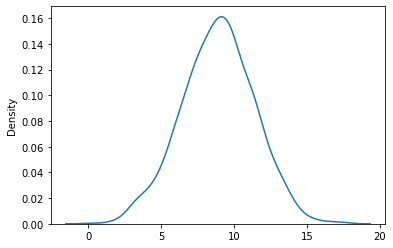

In [111]:
import seaborn as sns

with model3:
#     az.plot_trace(trace3)
#     print(np.shape(trace3['x']))
#     print(max(trace3['x'][:,317]))
    sns.distplot(trace3['x'][:,317], hist = False)

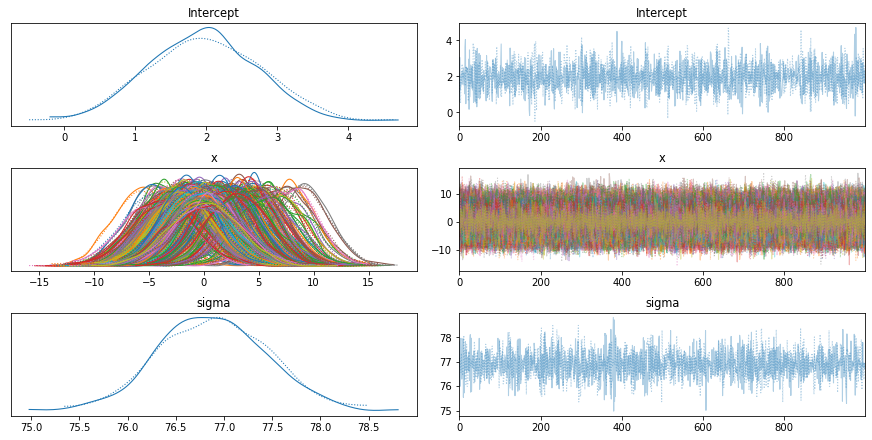

In [95]:
with model3:
    az.plot_trace(trace3)

## Next: Compare these results with ridge regression and standard linear regression

#### First - Linear Regression

Note - these results are very weird. Seems like the coefficients are either blowing up or going to zero. Perhaps ridge will be better.

In [152]:
# Linear Reg first:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x, y)

In [153]:
reg.score(x,y)
reg.coef_

array([ 8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  

## Ridge Regression

Below we fit a ridge regression model to the data and select a regularization parameter alpha using cross validation. Interesting note - the model always selects the largest value for alpha that we allow it to. Not sure why this is.

The top coefficients in this model are for the following players:

* Steph Curry
* Al Horford
* Jared Dudley (strange)
* Giannis
* Ricky Rubio
* James Harden
* Luka Doncic
* Eric Gordon
* Terrence Ross
* Trey Burke

These results seem less reasonable than the results from Bayesian Regression. 

**Note** - these results are quite similar to Bayesian Regression with prior means all equal to zero. We see Jared Dudley in the top ten for that as well, along with Steph Curry, Al Horford, Giannis, Ricky Rubio, Harden, Luka Doncic, and Eric Gordon.

In [56]:
from sklearn.linear_model import RidgeCV

ridge_model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]).fit(x, y)
# cross validate for lambda

In [57]:
ridge_model.alpha_

100.0

In [146]:
player_index_map.loc[player_index_map.index == 184]

,player_id,index,player_name
184,203504.0,184,Trey Burke


In [58]:
coef_df = pd.DataFrame({'coefs': ridge_model.coef_, 'index': [i for i in range(len(ridge_model.coef_))]})
coef_df.sort_values(by = ['coefs']).tail(10)

,coefs,index
515,7.839445,515
59,8.424188,59
30,8.518778,30
335,8.643611,335
207,8.733329,207
95,9.245614,95
386,9.399328,386
71,9.658132,71
465,10.072219,465
317,10.225220,317


In [62]:
coef_df.to_csv(r'../data/ridge_coefs_main.csv')